In [33]:
from matplotlib import pyplot as plt
import numpy as np
from common_util import NogamiUTSData,NogamiUEData,NogamiConductivityData,setup_axis_default,hdi
from matplotlib import rc
import warnings
from typing import Tuple, Callable
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
import pickle
import copy
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

#ignore warnings and set preference for matplotlib styles
rc('font',**{'family':'serif','serif':['Times'],'weight': 'bold'})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

class ParamterizedLinearModel:

    """
    Need to pickle this for later, so just make it a class
    """
    def __init__(self,model: Pipeline,
                       model_spread: Pipeline = None) -> None:
        
        self.x,self.y = None,None
        self.model = copy.deepcopy(model)
        self.model_spread = copy.deepcopy(model if model_spread is None else model_spread)

    def fit_spread(self, x: np.ndarray,y: np.ndarray, 
                        *args,alpha = 0.95,**kwargs) -> None:
        
        ci = hdi(y,alpha = alpha).T
        d = 0.5*(ci[1] - ci[0])
        self.model_spread.fit(x,0.5*(ci[1] - ci[0]),*args,**kwargs)
        d_max = d.max()
        self.gamma_bracket = (-d_max*2,d_max*2)

    def fit_mean(self, x: np.ndarray,y: np.ndarray,*args,**kwargs) -> None:
        self.model.fit(x,y,*args,**kwargs)

    def __call__(self,xnew: np.ndarray,gamma: float) -> np.ndarray:
        return self.model.predict(xnew).squeeze() + gamma*self.model_spread.predict(xnew).squeeze()
    
    def find_gamma(self,material_model: Callable,xlim: Tuple[float,float]) -> float:
        return self._find_closest_model(material_model,self,xlim,self.gamma_bracket)
    
    def mean_value(self,xlim: Tuple[float],gamma: float) -> float:
        def integrate(x: float):
            _x = np.array([x])[:,np.newaxis]
            return self(_x,gamma)

        return 1/(xlim[1] - xlim[0])*quad(integrate,*xlim)[0]

    
    @staticmethod
    def _find_closest_model(material_model: Callable,
                            parametric_model: Callable,
                            xlim: Tuple[float,float],
                            gamma_lim: Tuple[float,float]):
        
        """
        Could have done using analytical integrals, but this is easier to implemnt. 
        """
        
        def model_diff(gamma: float):
            
            def wrapped(x: float):
                _x = np.array([x])[:,np.newaxis]
                y = material_model(_x) - parametric_model(_x,gamma)
                return y
            
            return np.abs(quad(wrapped,*xlim)[0])

        res = minimize_scalar(model_diff,bounds = gamma_lim)
        if res.success:
            return res.x
        else:
            raise ValueError("Optimization failed")

def inner_product(f: Callable,
                  g: Callable,
                  xlim: Tuple[float,float]) -> float:

    return quad(lambda x: f(x)*g(x),xlim[0],xlim[1])[0]

def function_norm(f: Callable,
                  xlim: Tuple[float,float]) -> float:

    return np.sqrt(inner_product(f,f,xlim))


#load data


### Ultimate Tensile Strength
_shape_ posterior samples they can be fit with (zero mean function) GP, the parameterization is thus variance of the GP.

fitting material model: UTS [MPa] K-W3%Re Plate (L)
gamma: -0.017625479492030034 | mean value: 661.2087638382604
----------------------------------------

fitting material model: UTS [MPa] K-W3%Re Plate (H)
gamma: 0.934698623209676 | mean value: 763.2543217709346
----------------------------------------

fitting material model: UTS [MPa] W Plate (H)
gamma: -0.820504885635762 | mean value: 575.1768376062575
----------------------------------------



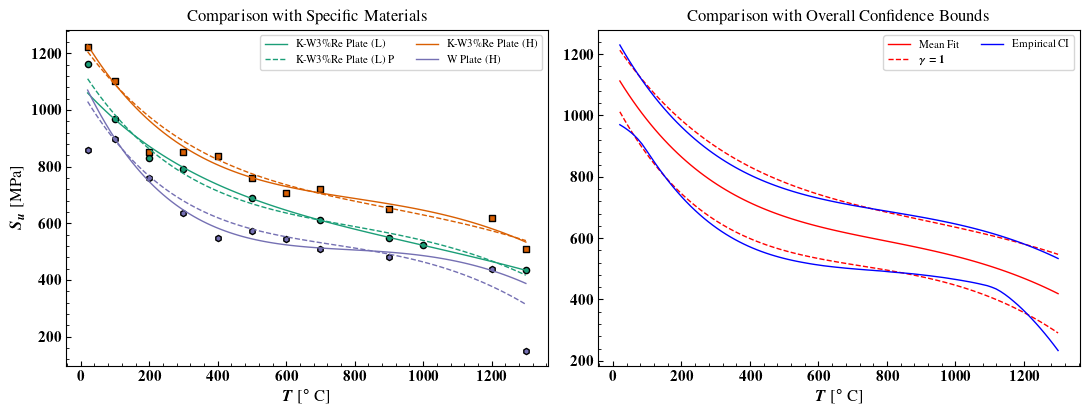

In [34]:
nogami_data = NogamiUTSData()
with open(f'.scratch/uts_posterior_samples.pkl','rb') as f: 
    xs,ys_ =  pickle.load(f)

#some shaping of the samples
with open(f".model/UTS [MPa] K-W3%Re Plate (H)_uts.pkl","rb") as f:
    model = pickle.load(f)  
    ymax = model.predict(xs)

for i in range(ys_.shape[0]):
    ys_[i,ys_[i] > ymax[i]] = ymax[i]

Xs = np.repeat(xs,ys_.shape[1],axis = 0).flatten()[:,np.newaxis]
ys = ys_.flatten()

pmodel_base = copy.deepcopy(model)  

parametric_model = ParamterizedLinearModel(pmodel_base)
parametric_model.fit_mean(Xs,ys)
parametric_model.fit_spread(xs,ys_)

fig, axes = plt.subplots(ncols = 2,figsize = (11,4.25))
for ax in axes:
    setup_axis_default(ax)

colors = plt.get_cmap('Dark2')(list(range(len(nogami_data.keys()))))

labels = {'UTS [MPa] K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'UTS [MPa] K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)',
          'UTS [MPa] W Plate (H)': 'W Plate (H)'}

markers = ['o','s','h']
i_ = 0
axes[0].set_title('Comparison with Specific Materials')
for col,color,marker in zip(labels,colors,markers):
    print(f'fitting material model: {col}')
    with open(f".model/{col}_uts.pkl","rb") as f:
        model = pickle.load(f)
    
    gamma = parametric_model.find_gamma(lambda x: model.predict(x).squeeze(),(xs.min(),xs.max()))
    mv = parametric_model.mean_value((xs.min(),xs.max()),gamma)
    
    print(f'gamma: {gamma} | mean value: {mv}')   

    print('----------------------------------------\n')
    axes[0].plot(xs,model.predict(xs).squeeze(),label = labels[col],color = color,linestyle = '-',lw = 1.0)
    axes[0].plot(xs,parametric_model(xs,gamma).squeeze(),label = f'{labels[col]} P' if i_ == 0 else None,
            color = color,linestyle = '--',lw = 1.0)

    axes[0].scatter(*nogami_data[col], s = 20,marker = marker,color = color,edgecolor = 'k')
    i_ +=1

axes[1].set_title('Comparison with Overall Confidence Bounds')


axes[1].plot(xs,parametric_model(xs,0),color = 'red',linestyle = '-',lw = 1.0,label = 'Mean Fit')
axes[1].plot(xs,parametric_model(xs,1),color = 'red',linestyle = '--',lw = 1.0,label = r'$\gamma = 1$')
axes[1].plot(xs,parametric_model(xs,-1),color = 'red',linestyle = '--',lw = 1.0)

confidence_intervals = hdi(ys_,alpha = 0.95).T

for i,ci in enumerate(confidence_intervals):
    model = copy.deepcopy(pmodel_base)

    #plot samples
    axes[1].plot(xs,ci,color = 'blue',linestyle = '-',lw = 1.0,
                 label = 'Empirical CI' if i == 0 else None)

axes[0].set_ylabel(r'$S_{u}$ [MPa]',fontsize = 12)
for ax in axes:
    ax.legend(ncol = 2,fontsize = 8)
    ax.set_xlabel(r'$T$ [$^\circ$ C]',fontsize = 12)

fig.tight_layout()


### Uniform Elongation

fitting material model: UE [%] K-W3%Re Plate (L)
gamma: 1.0718756285958124 | mean value: 5.134738236457966
----------------------------------------

fitting material model: UE [%] K-W3%Re Plate (H)
gamma: 0.0880181485155354 | mean value: 2.9291358221645294
----------------------------------------

fitting material model: UE [%] W Plate (H)
gamma: -0.6441935479218349 | mean value: 1.2876705508892776
----------------------------------------



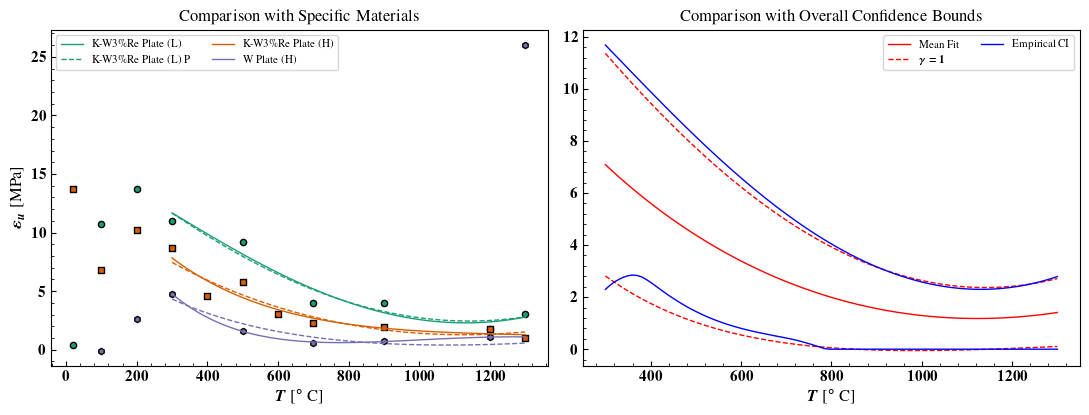

In [35]:
nogami_data = NogamiUEData()
with open(f'.scratch/ue_posterior_samples.pkl','rb') as f: 
    xs,ys_ =  pickle.load(f)

#some shaping of the samples
with open(f".model/UE [%] K-W3%Re Plate (L)_ue.pkl","rb") as f:
    model = pickle.load(f)  
    ymax = model.predict(xs)

for i in range(ys_.shape[0]):
    ys_[i,ys_[i] > ymax[i]] = ymax[i]

ys_[ys_ < 0] = 0

Xs = np.repeat(xs,ys_.shape[1],axis = 0).flatten()[:,np.newaxis]
ys = ys_.flatten()

pmodel_base = copy.deepcopy(model)  

parametric_model = ParamterizedLinearModel(pmodel_base)
parametric_model.fit_mean(Xs,ys)
parametric_model.fit_spread(xs,ys_)

fig, axes = plt.subplots(ncols = 2,figsize = (11,4.25))
for ax in axes:
    setup_axis_default(ax)

colors = plt.get_cmap('Dark2')(list(range(len(nogami_data.keys()))))

labels = {'UE [%] K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'UE [%] K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)',
          'UE [%] W Plate (H)': 'W Plate (H)'}

markers = ['o','s','h']
i_ = 0
axes[0].set_title('Comparison with Specific Materials')
for col,color,marker in zip(labels,colors,markers):
    print(f'fitting material model: {col}')
    with open(f".model/{col}_ue.pkl","rb") as f:
        model = pickle.load(f)
    
    gamma = parametric_model.find_gamma(lambda x: model.predict(x).squeeze(),(xs.min(),xs.max()))
    mv = parametric_model.mean_value((xs.min(),xs.max()),gamma)
    print(f'gamma: {gamma} | mean value: {mv}')   

    print('----------------------------------------\n')
    axes[0].plot(xs,model.predict(xs).squeeze(),label = labels[col],color = color,linestyle = '-',lw = 1.0)
    axes[0].plot(xs,parametric_model(xs,gamma).squeeze(),label = f'{labels[col]} P' if i_ == 0 else None,
            color = color,linestyle = '--',lw = 1.0)

    axes[0].scatter(*nogami_data[col], s = 20,marker = marker,color = color,edgecolor = 'k')
    i_ +=1

axes[1].set_title('Comparison with Overall Confidence Bounds')

axes[1].plot(xs,parametric_model(xs,0.),color = 'red',linestyle = '-',lw = 1.0,label = 'Mean Fit')
axes[1].plot(xs,parametric_model(xs,1.),color = 'red',linestyle = '--',lw = 1.0,label = r'$\gamma = 1$')
axes[1].plot(xs,parametric_model(xs,-1.),color = 'red',linestyle = '--',lw = 1.0)

confidence_intervals = hdi(ys_,alpha = 0.95).T

for i,ci in enumerate(confidence_intervals):
    model = copy.deepcopy(pmodel_base)

    #plot samples
    axes[1].plot(xs,ci,color = 'blue',linestyle = '-',lw = 1.0,
                 label = 'Empirical CI' if i == 0 else None)

axes[0].set_ylabel(r'$\varepsilon_{u}$ [MPa]',fontsize = 12)
for ax in axes:
    ax.legend(ncol = 2,fontsize = 8)
    ax.set_xlabel(r'$T$ [$^\circ$ C]',fontsize = 12)

fig.tight_layout()


### Conductivity

fitting material model: W-1%Re (H) Plate
gamma: -0.16921484124567096 | mean value: 120.22977791530326
----------------------------------------

fitting material model: K-doped W-3%Re (H) Plate
gamma: -0.6817659093276983 | mean value: 111.68851007134056
----------------------------------------

fitting material model: Pure W (H) Plate
gamma: 1.031620126452763 | mean value: 140.24076556944885
----------------------------------------



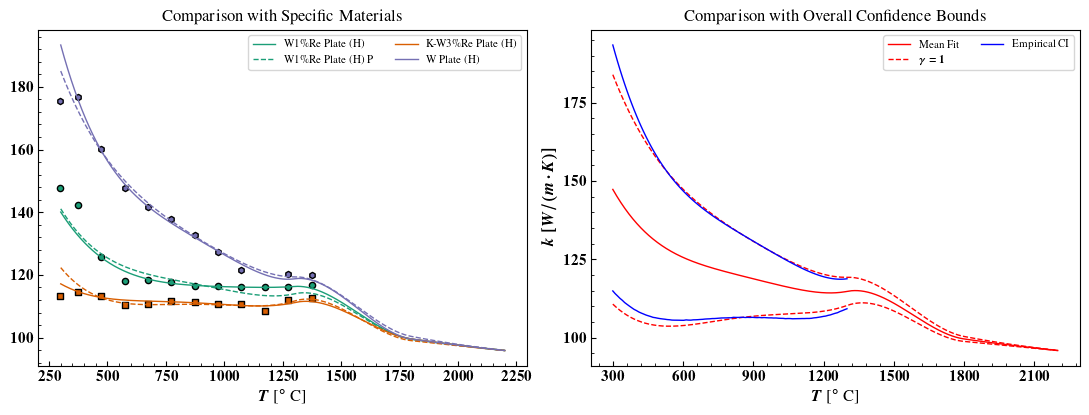

In [41]:
from common_util import StichPolynomialSplineModel

nogami_data = NogamiConductivityData()

with open(f'.scratch/conductivity_posterior_samples.pkl','rb') as f: 
    xs,ys_ =  pickle.load(f)

with open(f'.scratch/conductivity_total_samples.pkl','rb') as f: 
    xt,yt_ =  pickle.load(f)

#some shaping of the samples
with open(f".model/Pure W (H) Plate_cond.pkl","rb") as f:
    model = pickle.load(f)  
    ymax = model.predict(xs)

for i in range(ys_.shape[0]):
    ys_[i,ys_[i] > ymax[i]] = ymax[i]
    yt_[i,yt_[i] > ymax[i]] = ymax[i]



Xs = np.repeat(xs,ys_.shape[1],axis = 0).flatten()[:,np.newaxis]
Xt = np.repeat(xt,yt_.shape[1],axis = 0).flatten()[:,np.newaxis]
ys = ys_.flatten()
yt = yt_.flatten()
pmodel_base = copy.deepcopy(model)  

T_eval = np.array([1300.,1800.])[:,np.newaxis]   
parametric_model = ParamterizedLinearModel(pmodel_base,model_spread= pmodel_base.model)
parametric_model.fit_mean(Xs,ys,T_eval)
parametric_model.fit_spread(xt,yt_)

fig, axes = plt.subplots(ncols = 2,figsize = (11,4.25))
for ax in axes:
    setup_axis_default(ax)

colors = plt.get_cmap('Dark2')(list(range(len(nogami_data.keys()))))

labels = {'W-1%Re (H) Plate':r'W1\%Re Plate (H)',
          'K-doped W-3%Re (H) Plate': r'K-W3\%Re Plate (H)',
          'Pure W (H) Plate': r'W Plate (H)'}

markers = ['o','s','h']
i_ = 0
axes[0].set_title('Comparison with Specific Materials')
xplot = np.linspace(xs.min(),2200,1000)[:,np.newaxis]
for col,color,marker in zip(labels,colors,markers):
    print(f'fitting material model: {col}')
    with open(f".model/{col}_cond.pkl","rb") as f:
        model = pickle.load(f)
    
    gamma = parametric_model.find_gamma(lambda x: model.predict(x).squeeze(),(xs.min(),xs.max()))
    mv = parametric_model.mean_value((xs.min(),xs.max()),gamma)

    print(f'gamma: {gamma} | mean value: {mv}')   

    print('----------------------------------------\n')
    axes[0].plot(xplot,model.predict(xplot).squeeze(),label = labels[col],color = color,linestyle = '-',lw = 1.0)
    axes[0].plot(xplot,parametric_model(xplot,gamma).squeeze(),label = rf'{labels[col]} P' if i_ == 0 else None,
            color = color,linestyle = '--',lw = 1.0)

    axes[0].scatter(*nogami_data[col], s = 20,marker = marker,color = color,edgecolor = 'k')
    i_ +=1

axes[1].set_title('Comparison with Overall Confidence Bounds')

axes[1].plot(xplot,parametric_model(xplot,0.),color = 'red',linestyle = '-',lw = 1.0,label = 'Mean Fit')
axes[1].plot(xplot,parametric_model(xplot,1.),color = 'red',linestyle = '--',lw = 1.0,label = r'$\gamma = 1$')
axes[1].plot(xplot,parametric_model(xplot,-1.),color = 'red',linestyle = '--',lw = 1.0)

confidence_intervals = hdi(ys_,alpha = 0.95).T

for i,ci in enumerate(confidence_intervals):
    model = copy.deepcopy(pmodel_base)

    #plot samples
    axes[1].plot(xs,ci,color = 'blue',linestyle = '-',lw = 1.0,
                 label = 'Empirical CI' if i == 0 else None)

ax.set_xlabel(r'Temperature [$^\circ C$]',fontsize = 12)
ax.set_xticks(np.arange(300,2300,300))
ax.set_yticks(np.arange(100,200,25))
ax.set_ylabel(r'$k \ [W/(m \cdot K)]$',fontsize = 12)

for ax in axes:
    ax.legend(ncol = 2,fontsize = 8)
    ax.set_xlabel(r'$T$ [$^\circ$ C]',fontsize = 12)

fig.tight_layout()
